# Лабораторная работа № 3   
### Предсказание породы собак по фотографии   
Датасет взят с Kaggle: https://www.kaggle.com/competitions/dpl302m-project-1-dog-breed-identification/

In [5]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from pathlib import Path
from torchvision.io import read_image
import seaborn as sns
from time import time

path = '/content/'

dogs = pd.read_csv(f'{path}labels.csv')

classes = pd.unique(dogs['breed'])
print(display(dogs))


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


None


In [6]:
# присвоим классам численные значения и запишим в новый файл
dogs['class_id'] = pd.factorize(dogs.breed)[0]
dogs.head(20)
dogs.to_csv(f'{path}/dogs.csv', index=False)

In [ ]:
dogs.info()
dogs['breed'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10222 non-null  object
 1   breed     10222 non-null  object
 2   class_id  10222 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 239.7+ KB


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

Вследствие того, что метки есть только для изображений из папки train - это и будет наша выборка, с которой далее будем работать и дополнительно делить на подвыборки. В данном датасете отсутствуют пропущенные значения. Общее количество экземпляров 10222. Выборка несбалансированная. Максимальная встречаемость класса scottish_deerhound (126 раз), минимальная у классов eskimo_dog и briard (66 раз).

In [7]:
# создадим класс DogBreed (потомок Dataset)
class DogBreed(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg') # путь к изображению
        image = read_image(img_path) # чтение изображения
        label = self.img_labels.iloc[idx, 2] # чтение метки
        if self.transform:
            image = self.transform(image) # трансформация изображения
        if self.target_transform:
            label = self.target_transform(label) # трансформация метки использоваться не будет, но оставим
        return image, label

In [8]:
# преобразования, который необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.ToPILImage(), # функция plt.imshow без данного преобразования не принимала изображения
     transforms.Resize((224,224)),  # изменим размер изображений на тот, что в документации к ResNet
     transforms.CenterCrop(224),
     transforms.ToTensor(),   # переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # проведем нормализацию изображения к ResNet

In [9]:
# преобразуем датасет в датасет torch
ds = DogBreed(csv_file=(f'{path}dogs.csv'),
                    img_dir=(f'{path}train/'), transform=transform)


In [10]:
# разделим рандомно на подвыборки
train_ds, test_ds = torch.utils.data.random_split(ds, [8722, 1500]) # т.к. выборка относительно мала, на валидационную делить не будем
# проверим общую длину
len(train_ds) + len(test_ds)

10222

In [ ]:
# подсчитаем количество представленных классов в тестовой и обучающей выборках
# необходимо чтобы было представленно по 120
n_class_train = []
n_class_test = []

for data in train_ds:
    labels = data[1]
    n_class_train.append(labels)
print('Количество уникальных классов в train_ds =', len(set(n_class_train)))

for data in test_ds:
    labels = data[1]
    n_class_test.append(labels)
print('Количество уникальных классов в test_ds =', len(set(n_class_test)))


Количество уникальных классов в train_ds = 120
Количество уникальных классов в test_ds = 120


In [11]:
# загрузим выборки в DataLoader, пусть размер бача будет небольшим
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [12]:
# функция для вывода изображений и меток для проверки
def image_shower(images, labels, n=4): # четыре примера хватит
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image.permute(1, 2, 0).numpy() # Преобразуем тензор в формат (H, W, C)
        plt.imshow(image/2+0.5) # вывод и денормализация для смотрибельности
    print("Real Labels: ", ', '.join('%5s' % classes[label] for label in labels[:n])) # вывод названий пород

classes = pd.unique(dogs['breed'])

Real Labels:  toy_poodle, bluetick, irish_wolfhound, briard


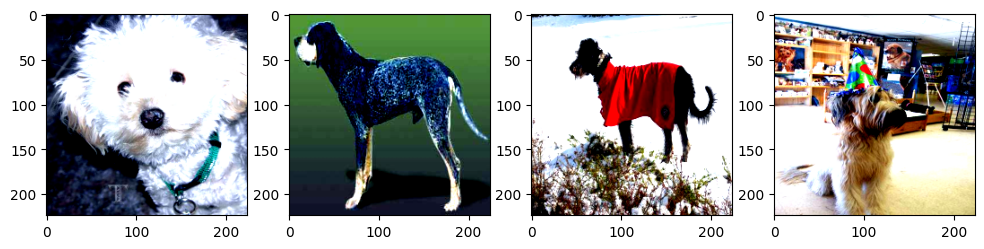

In [14]:
# проверим работу загрузчика
images, labels = next(iter(train_loader))
image_shower(images, labels)

In [15]:
from torchvision.models.quantization import resnet50, ResNet50_QuantizedWeights
# загрузим предобученную модель. Например, ResNet50
model = torchvision.models.resnet50(pretrained=True)
# заморозим веса
for param in model.parameters():
    param.require = False

# инкодер не трогаем, у ResNet50 его последный слой равен 2048 нейронам
# последний слой декодера поменяем на количество наших классов (120)
model.fc = nn.Linear(2048, 120)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


cuda


In [16]:
# Зададим функцию потерь (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()
# Зададим оптимизатор (например, SGD)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

Обучение нейронной сети


273it [02:04,  2.20it/s]


test loss = 1.4172
Epoch 0 - Training loss: 3.3042585159832742 


273it [02:02,  2.22it/s]


test loss = 0.5817
Epoch 1 - Training loss: 0.9942389062909416 


273it [02:03,  2.21it/s]


test loss = 0.7043
Epoch 2 - Training loss: 0.6681308926461818 


273it [02:03,  2.20it/s]


test loss = 0.5422
Epoch 3 - Training loss: 0.4793034247480906 


273it [02:02,  2.23it/s]


test loss = 0.5302
Epoch 4 - Training loss: 0.3372362510134012 


273it [02:01,  2.24it/s]


test loss = 0.6029
Epoch 5 - Training loss: 0.26263950634133687 


273it [02:03,  2.22it/s]


test loss = 0.9592
Epoch 6 - Training loss: 0.1943228928365441 


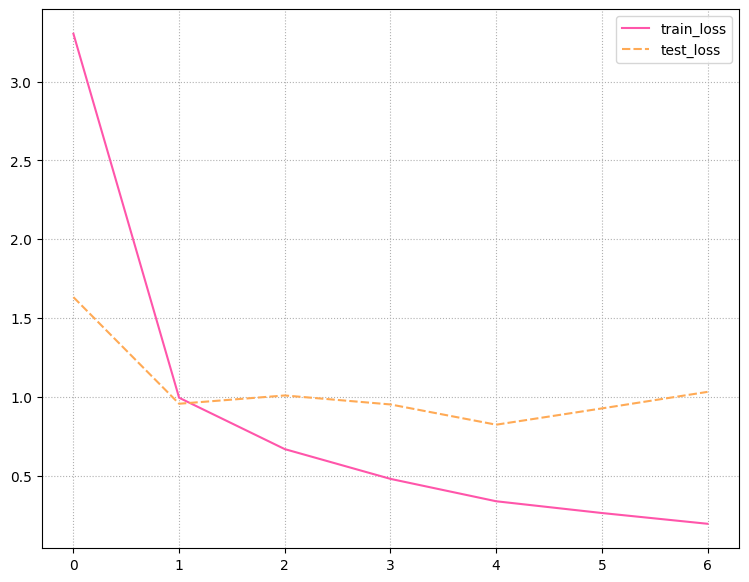


 Обучение нейросети закончено


In [17]:
print('Обучение нейронной сети')

epochs = 7   # количество эпох обучения
model.to(device) # переносим модель на GPU, если нет - то CPU

train_losses = []
test_losses = []

time0 = time()

for epoch in range(epochs):
    train_loss = 0.0
    # в цикле проходим по загрузчику данных
    for i, data in tqdm(enumerate(train_loader)):
        # каждый батч помещаем на GPU или CPU
        inputs, labels = data[0].to(device), data[1].to(device)
        # обнуляем накопленный градиент
        optimizer.zero_grad()
        # прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        # рассчет функции потерь
        loss = criterion(outputs, labels)
        # считаем градиенты (обратный проход)
        loss.backward()
        # делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        train_loss += loss.item()

    model.eval() # перевод модели в режим оценки
    test_loss = 0.0
    with torch.no_grad():
        for batch, labels in test_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch.float())
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    print(f'test loss = {loss.item():.4f}')

    train_losses.append(train_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))

    print ("Epoch {} - Training loss: {} ".format(epoch, train_loss/len(train_loader)))

torch.save(model, 'resnet50_dogs_7e.pth') # сохраним обученную модель

loss_list = list(zip(train_losses, test_losses))
losses = pd.DataFrame(loss_list, columns=['train_loss', 'test_loss'])
losses.to_csv('resnet50_losses.csv', index=False)
f = plt.figure(figsize = (9, 7))

sns.lineplot(data=losses, palette='spring')
plt.grid(ls = ':')
plt.show()

print('\n Обучение нейросети закончено')

По графику обучения видно, что после 5 эпохи процесс можно было останавливать, т.к. началось переобучение модели.

In [19]:
# посчитаем точность работы модели
from sklearn.metrics import f1_score
from torcheval.metrics import MulticlassF1Score
correct = 0
total = 0
total_labels = [] # список всех реальных классов в test_loader
total_predicted = [] # список всех предсказанных классов

metric = MulticlassF1Score(num_classes=4)
with torch.no_grad():
    # переводим модель в режим оценки
    model.eval()
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        # получаем предсказания
        _, predicted = torch.max(outputs.data, 1)
        # посчитаем общее количество картинок
        total += labels.size(0)
        # посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
        total_labels.append(labels) # добавление тензоров классов в список
        total_predicted.append(predicted)
# рассчет Accuracy
print("Accuracy: %d" %(100 * correct/total) + '%')

# рассчет метрик F1
f1micro = MulticlassF1Score(average='micro', num_classes=120)
f1micro.update(torch.cat(total_predicted), torch.cat(total_labels)) # объединение списка тензоров в один тензор и рассчет F1 
print('F1 micro =', round(f1micro.compute().item(), 2))
f1macro = MulticlassF1Score(average='macro', num_classes=120)
f1macro.update(predicted, labels)
print('F1 macro =', round(f1macro.compute().item(), 2))
f1w = MulticlassF1Score(average='weighted', num_classes=120)
f1w.update(predicted, labels)
print('F1 weighted =', round(f1w.compute().item(), 2))


Accuracy: 74%


F1 micro = 0.75
F1 macro = 0.57
F1 weighted = 0.69


Так как у нас несбалансированная выборка по классам, думаю, лучше ориентироваться на F1 weighted. В целом, из значений метрик видно, что точность нашей модели не очень высока. Значит необходимо более точно подойти к подбору гиперпараметров модели или выбрать другую предобученную модель.

Real Labels:  golden_retriever, norwegian_elkhound, siberian_husky, irish_terrier
Predicted:  golden_retriever, norwegian_elkhound, siberian_husky, irish_terrier


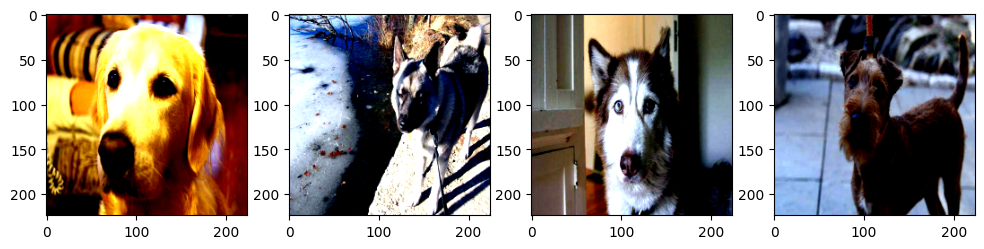

In [20]:
# проверим работу модели классификации на 4 примерах

images, labels = next(iter(test_loader))
image_shower(images, labels)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Predicted: ", ", ".join("%5s" %classes[predict] for predict in predicted[:4]))

В данном конкретном случае, классификатор правильно предсказал все четыре примера. Модель предсказания породы собак по фотографии в целом работает.